In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import json 
import random 
from warnings import filterwarnings
filterwarnings('ignore')
import math
from datetime import datetime


In [75]:
config = json.loads(open('config.json').read()) 
cifar_model_path = config["local"]["model_path"]
train= True
save_model = True

from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)  # 10 is the number of classes
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


In [76]:


# Data Augmentation and Rescaling for Training and Validation Sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
shear_range=0.2,    
zoom_range=0.2,
horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)  # Just rescaling for validation data
test_datagen = ImageDataGenerator(rescale=1./255)


# Create Training Set Generator
train_set = train_datagen.flow(
    x_train, y_train,        # Path to the folder containing training images     # Resize images to 150x150
    batch_size=32,                   # Process 32 images per batch
) 

val_set = val_datagen.flow(
    x_val, y_val, 
    batch_size=32
)

test_set = test_datagen.flow(
    x_test, y_test, 
    batch_size=32
)

In [77]:


# Define the CNN Model
classifier = Sequential([
    Conv2D(32, (3, 3), input_shape=(32, 32, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')  
])

In [79]:
# Compile the Model
classifier.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
early_stopping = True
if early_stopping:
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
else:
    early_stopping = None


# Train the Model
history = classifier.fit(
    train_set,
    epochs=200,
    validation_data=val_set,
    callbacks=[early_stopping]
)
    



Epoch 1/200
1250/1250 [==============================] - 14s 11ms/step - loss: 1.2868 - accuracy: 0.5428 - val_loss: 1.2505 - val_accuracy: 0.5625
Epoch 2/200
1250/1250 [==============================] - 15s 12ms/step - loss: 1.1601 - accuracy: 0.5921 - val_loss: 1.0687 - val_accuracy: 0.6269
Epoch 3/200
1250/1250 [==============================] - 15s 12ms/step - loss: 1.0655 - accuracy: 0.6275 - val_loss: 0.9864 - val_accuracy: 0.6547
Epoch 4/200
1250/1250 [==============================] - 13s 11ms/step - loss: 0.9945 - accuracy: 0.6506 - val_loss: 0.9861 - val_accuracy: 0.6564
Epoch 5/200
1250/1250 [==============================] - 16s 13ms/step - loss: 0.9432 - accuracy: 0.6704 - val_loss: 0.9957 - val_accuracy: 0.6597
Epoch 6/200
1250/1250 [==============================] - 14s 11ms/step - loss: 0.8942 - accuracy: 0.6856 - val_loss: 0.9028 - val_accuracy: 0.6823
Epoch 7/200
1250/1250 [==============================] - 13s 10ms/step - loss: 0.8579 - accuracy: 0.7009 - val_loss: 0

### Prediction of Single Image

1/1 [==============================] - 0s 52ms/step
Predicted Label: 9
True Label: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


Text(0, 0, 'Predicted Label: 9')

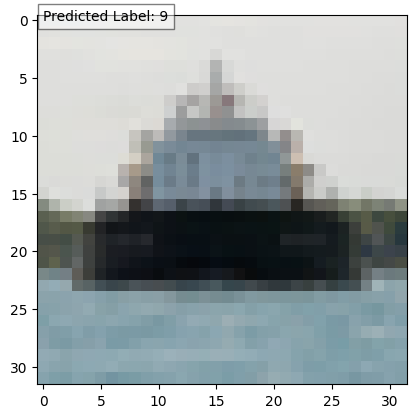

In [80]:
#get random image from train_set_folder
all_files = []
random_int= random.randint(0, x_train.shape[0]) 
to_plot= x_train[random_int]
label= y_train[random_int]
to_plot = np.expand_dims(to_plot, axis=0)
# Make prediction
prediction = classifier.predict(to_plot)  # No need for batch_size or steps arguments
predicted_label = np.argmax(prediction)
print(f"Predicted Label: {predicted_label}")
print(f"True Label: {label}")
plt.imshow(to_plot[0])
plt.text(0, 0, f"Predicted Label: {predicted_label}", bbox=dict(facecolor='white', alpha=0.5))



In [84]:

df = pd.DataFrame({
    'predict': predictions.argmax(axis=1),
    'y': y_test.argmax(axis=1) 
}) 


In [85]:
misclassified = df[df['y']!=df['predict']]
print('Total misclassified image from 5000 Validation images : %d'%misclassified['y'].count())

Total misclassified image from 5000 Validation images : 9010


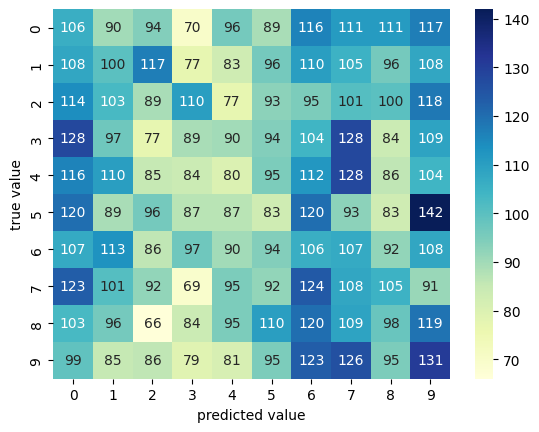

In [86]:
conf_matrix = confusion_matrix(df.y,df.predict)
sns.heatmap(conf_matrix,cmap="YlGnBu",annot=True,fmt='g');
plt.xlabel('predicted value')
plt.ylabel('true value');

## New model for Cifar-10, based on VGG16 architecture


Redefine Model using: 
1) Additional layers to add robustness to the model
2) Normalisation for model stability
3) Additional dropout to prevent overfitting

In [92]:
def build_VGG10_model (myInitializer="glorot_uniform", myLoss="categorical_crossentropy", myOptimizer="adam", myMetrics=["accuracy"], myActivation='relu', myDropout_Conv=0.3, myDropout_Dense=0.3):

    model = Sequential()

    model.add(Conv2D(filters=32,kernel_size=(3,3), padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(Conv2D(filters=32, padding='same', kernel_size=(3,3)))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(myDropout_Conv))

    model.add(Conv2D(filters=64,kernel_size=(3,3), padding='same' ))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same' ))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(myDropout_Conv))

    model.add(Conv2D(filters=128,kernel_size=(3,3), padding='same' ))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same' ))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(myDropout_Conv))

    model.add(Flatten())

    model.add(Dense(2048, use_bias=False, kernel_initializer=myInitializer))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(Dropout(myDropout_Dense))

    model.add(Dense(1024, use_bias=False, kernel_initializer=myInitializer))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(Dropout(myDropout_Dense))

    model.add(Dense(512, use_bias=False, kernel_initializer=myInitializer))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(Dropout(myDropout_Dense))

    model.add(Dense(128, use_bias=False, kernel_initializer=myInitializer))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(Dropout(myDropout_Dense))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss=myLoss, optimizer=myOptimizer, metrics=myMetrics) 

    return model

In [96]:
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPool2D, Dropout 
model2 = build_VGG10_model()

In [97]:
model2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
if train:
    history2 = model2.fit(
        train_set,
        epochs=200,
        validation_data=val_set,
        callbacks=[early_stopping]
    )

    if save_model:
        model2.save(cifar_model_path)
        print(f"Model saved at {cifar_model_path}")
    else:
        print("Model not saved")
else:
    model2 = tf.keras.models.load_model(cifar_model_path)
    print(f"Model loaded from {cifar_model_path}")
    

Epoch 1/200
1250/1250 [==============================] - 200s 159ms/step - loss: 1.6686 - accuracy: 0.4006 - val_loss: 1.4826 - val_accuracy: 0.4761
Epoch 2/200
 768/1250 [=================>............] - ETA: 1:04 - loss: 1.3202 - accuracy: 0.5318